# Tutorial to implement GAN using PyTorch
This is a simple example to grasp the concept of GAN framework. We will build our version from scratch afterward \
https://realpython.com/generative-adversarial-networks/#handwritten-digits-generator-with-a-gan

In [1]:
!nvidia-smi

Thu Dec 19 01:24:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:35:00.0 Off |                    0 |
| N/A   28C    P8              11W /  72W |      0MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader

In [148]:
# Enable GPU if possible

torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Transform MNIST in tensor with normalized values
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.CIFAR100(
    root=".", train=True, download=True, transform=transform
)

print(train_set)

###################################
# Subset of digit
##################################
def filter_digits(target_digits=[0,1,2,3]):
    # Filter the dataset based on the target digits
    indices = [i for i, label in enumerate(train_set.targets) if label.item() in target_digits]
    filtered_data = [train_set.data[i] for i in indices]
    filtered_labels = [train_set.targets[i] for i in indices]
    
    # Convert the data to a 4D tensor by adding a channel dimension
    filtered_data = torch.stack([img.unsqueeze(0) for img in filtered_data])
    
    return torch.utils.data.TensorDataset(filtered_data, torch.tensor(filtered_labels))
    
# train_set = filter_digits(target_digits=[2, 4])

print(train_set)

##################################       
# Separate tensor into batch for PyTorch
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

Files already downloaded and verified
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


## Show some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([3, 32, 32])


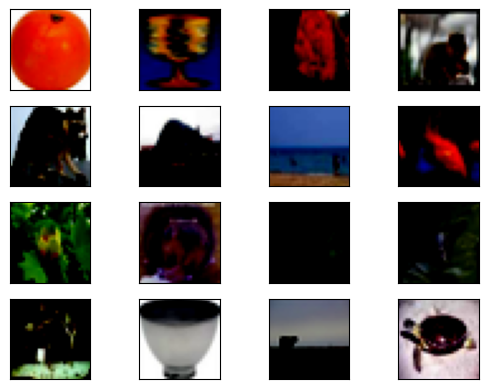

In [149]:
real_samples, mnist_labels = next(iter(train_loader))
print(real_samples[0].shape)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].permute(1, 2, 0))  # permute to (32, 32, 3)
    plt.xticks([])
    plt.yticks([])

## Implement Generator & Discriminator

In [150]:
# use CNN

# class Discriminator(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = torch.nn.Sequential(
#             torch.nn.Linear(1024, 2048),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.3),
#             torch.nn.Linear(2048, 1024),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.3),
#             torch.nn.Linear(1024, 512),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.3),
#             torch.nn.Linear(512, 256),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.3),
#             torch.nn.Linear(256, 1),
#             torch.nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), 1024)
#         output = self.model(x)
#         return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # First convolutional layer: takes 3-channel 32x32 image
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),  # Output: (batch_size, 64, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Second convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (batch_size, 128, 8, 8)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Third convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Output: (batch_size, 256, 4, 4)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Fourth convolutional layer
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # Output: (batch_size, 512, 2, 2)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Final convolution to flatten to 1x1 (batch_size, 1, 1, 1)
            nn.Conv2d(512, 1, kernel_size=2, stride=2, padding=0),  # Output: (batch_size, 1, 1, 1)
            nn.Sigmoid()  # Sigmoid to output value between 0 and 1
        )

    def forward(self, x):
        # Pass input through the model
        x = self.model(x)
        # Flatten the output to (batch_size, 1)
        x = x.view(x.size(0), -1)
        return x
    
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Fully connected layer: Transforms the input noise vector into a feature map
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.BatchNorm1d(128 * 8 * 8),
            nn.ReLU()
        )
        
        self.features = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Tanh() # Output pixel values mapped to [-1, 1]
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 8, 8)
        return self.features(x)


discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

### Hyperparameters

In [151]:
lr = 0.0001
lr_generator = 2e-4
lr_discriminator = 1e-4

epoch = 1
num_epochs = 10
loss_function = torch.nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_discriminator)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_generator)

In [152]:
import datetime
import os

def save_images(epoch, nb_of_images=16):
    # save generated samples
    latent_space_samples = torch.randn(nb_of_images, 100).to(device=device)
    generated_samples = generator(latent_space_samples)

    generated_samples = generated_samples.cpu().detach()

    date_now = datetime.datetime.now()
    folder_id = date_now.strftime("%m")
    folder_id += '.'
    folder_id += date_now.strftime("%d")
    folder_id += '-'
    folder_id += date_now.strftime("%H")
    folder_id += '.'
    folder_id += date_now.strftime("%M")

    # data_dir_path = os.path.join(os.path.dirname(__file__), "data", folder_id)
    # if not os.path.exists(folder_id):
    #     os.mkdir(folder_id)
    
    nb_of_images = int(nb_of_images / 4) * 4
    height_of_plot = int(nb_of_images / 4)
    plt.figure(figsize=(8, (height_of_plot / 4 * 6))) 
    
    for i in range(nb_of_images):
        ax = plt.subplot(height_of_plot, 4, i + 1)
        
        plt.imshow(generated_samples[i].permute(1, 2, 0))
        plt.xticks([])
        plt.yticks([])
    plt.savefig(f'{folder_id}_epoch{epoch}.png')
    plt.close()

### Train models using GAN framework

In [154]:
import numpy as np

# Data for training the discriminator
real_samples = real_samples.to(device=device)

print(device)

real_samples_labels = 0.9*torch.ones((batch_size, 1)).to(
    device=device
) # label smoothing

num_epochs = 500
for epoch in range(epoch, num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):       

        # cache in gpu
        real_samples = real_samples.to(device)
        real_samples_labels = real_samples_labels.to(device)
        mnist_labels = mnist_labels.to(device)
        
        latent_space_samples = torch.randn((batch_size, 100), device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = 0.1*torch.ones((batch_size, 1), device=device) # label smoothing



        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch}")
            print(f" Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")

    if epoch % 20 == 0:
        save_images(epoch, nb_of_images=100)
        
        
# torch.save({
#     'epoch': epoch,
#     'discriminator_state_dict': discriminator.state_dict(),
#     'generator_state_dict': generator.state_dict(),
#     'optimizer_D_state_dict': optimizer_discriminator.state_dict(),
#     'optimizer_G_state_dict': optimizer_generator.state_dict(),
#     'loss_D': loss_discriminator,
#     'loss_G': loss_generator,
# }, 'checkpoint.pth')            

save_images(epoch, nb_of_images=300)

print("model and image saved")


cuda
Epoch: 19
 Loss D.: 0.4916095733642578, Loss G.: 1.1230006217956543
Epoch: 20
 Loss D.: 0.5588310360908508, Loss G.: 1.031934142112732


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 21
 Loss D.: 0.5643012523651123, Loss G.: 1.2289328575134277
Epoch: 22
 Loss D.: 0.5428012609481812, Loss G.: 1.2181389331817627
Epoch: 23
 Loss D.: 0.43958938121795654, Loss G.: 1.2782697677612305
Epoch: 24
 Loss D.: 0.5316550731658936, Loss G.: 1.493485927581787
Epoch: 25
 Loss D.: 0.5380449295043945, Loss G.: 1.4150886535644531
Epoch: 26
 Loss D.: 0.5791928768157959, Loss G.: 1.2828547954559326
Epoch: 27
 Loss D.: 0.48103612661361694, Loss G.: 1.404973030090332
Epoch: 28
 Loss D.: 0.5230328440666199, Loss G.: 1.4601244926452637
Epoch: 29
 Loss D.: 0.4975385069847107, Loss G.: 1.1260215044021606
Epoch: 30
 Loss D.: 0.5289493203163147, Loss G.: 1.055036187171936
Epoch: 31
 Loss D.: 0.5055679082870483, Loss G.: 1.2761132717132568
Epoch: 32
 Loss D.: 0.5162438750267029, Loss G.: 1.3416060209274292
Epoch: 33
 Loss D.: 0.5249797701835632, Loss G.: 1.1786524057388306
Epoch: 34
 Loss D.: 0.537828803062439, Loss G.: 1.2168091535568237
Epoch: 35
 Loss D.: 0.5593407154083252, Loss G.: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 41
 Loss D.: 0.5166321992874146, Loss G.: 1.2612907886505127
Epoch: 42
 Loss D.: 0.563399076461792, Loss G.: 0.984939455986023
Epoch: 43
 Loss D.: 0.537401556968689, Loss G.: 1.0749869346618652
Epoch: 44
 Loss D.: 0.5616123676300049, Loss G.: 1.2127079963684082
Epoch: 45
 Loss D.: 0.6278429627418518, Loss G.: 1.2007309198379517
Epoch: 46
 Loss D.: 0.5615501403808594, Loss G.: 1.0263543128967285
Epoch: 47
 Loss D.: 0.42930883169174194, Loss G.: 0.9571331739425659
Epoch: 48
 Loss D.: 0.5758650898933411, Loss G.: 1.2411084175109863
Epoch: 49
 Loss D.: 0.668720543384552, Loss G.: 0.9908501505851746
Epoch: 50
 Loss D.: 0.5183833241462708, Loss G.: 1.163713812828064
Epoch: 51
 Loss D.: 0.5271100997924805, Loss G.: 1.0196727514266968
Epoch: 52
 Loss D.: 0.5493897795677185, Loss G.: 1.039646863937378
Epoch: 53
 Loss D.: 0.5220643877983093, Loss G.: 1.237257719039917
Epoch: 54
 Loss D.: 0.5562021732330322, Loss G.: 1.1251707077026367
Epoch: 55
 Loss D.: 0.5217787623405457, Loss G.: 1.267

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 61
 Loss D.: 0.5592777729034424, Loss G.: 0.9732732772827148
Epoch: 62
 Loss D.: 0.5829436182975769, Loss G.: 1.1463592052459717
Epoch: 63
 Loss D.: 0.5657463073730469, Loss G.: 1.080076813697815
Epoch: 64
 Loss D.: 0.5412208437919617, Loss G.: 1.0302844047546387
Epoch: 65
 Loss D.: 0.6395233273506165, Loss G.: 0.984877347946167
Epoch: 66
 Loss D.: 0.49728870391845703, Loss G.: 1.0851014852523804
Epoch: 67
 Loss D.: 0.5559952259063721, Loss G.: 1.1251778602600098
Epoch: 68
 Loss D.: 0.5294610261917114, Loss G.: 1.252364993095398
Epoch: 69
 Loss D.: 0.5341202020645142, Loss G.: 1.0910600423812866
Epoch: 70
 Loss D.: 0.5326486825942993, Loss G.: 1.089820146560669
Epoch: 71
 Loss D.: 0.53368079662323, Loss G.: 1.0532962083816528
Epoch: 72
 Loss D.: 0.4871451258659363, Loss G.: 1.0835952758789062
Epoch: 73
 Loss D.: 0.5801054239273071, Loss G.: 1.0061436891555786
Epoch: 74
 Loss D.: 0.5246329307556152, Loss G.: 1.1381304264068604
Epoch: 75
 Loss D.: 0.5843954086303711, Loss G.: 1.11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 81
 Loss D.: 0.5703887939453125, Loss G.: 1.1564605236053467
Epoch: 82
 Loss D.: 0.5592018365859985, Loss G.: 1.220360517501831
Epoch: 83
 Loss D.: 0.5644023418426514, Loss G.: 1.1001012325286865
Epoch: 84
 Loss D.: 0.5633269548416138, Loss G.: 1.1659510135650635
Epoch: 85
 Loss D.: 0.5974082946777344, Loss G.: 1.051703929901123
Epoch: 86
 Loss D.: 0.5527093410491943, Loss G.: 1.115447759628296
Epoch: 87
 Loss D.: 0.6104663610458374, Loss G.: 0.870966374874115
Epoch: 88
 Loss D.: 0.5195767879486084, Loss G.: 1.136859655380249
Epoch: 89
 Loss D.: 0.5594054460525513, Loss G.: 1.0489046573638916
Epoch: 90
 Loss D.: 0.560417115688324, Loss G.: 1.1791497468948364
Epoch: 91
 Loss D.: 0.5600329637527466, Loss G.: 1.047281265258789
Epoch: 92
 Loss D.: 0.6184204816818237, Loss G.: 0.977711021900177
Epoch: 93
 Loss D.: 0.5270992517471313, Loss G.: 0.9259198904037476
Epoch: 94
 Loss D.: 0.523139476776123, Loss G.: 1.2137672901153564
Epoch: 95
 Loss D.: 0.5513104200363159, Loss G.: 0.998478

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 101
 Loss D.: 0.5808010697364807, Loss G.: 1.131486177444458
Epoch: 102
 Loss D.: 0.5670756101608276, Loss G.: 1.0500431060791016
Epoch: 103
 Loss D.: 0.5009225606918335, Loss G.: 1.0210095643997192
Epoch: 104
 Loss D.: 0.5507900714874268, Loss G.: 1.065368890762329
Epoch: 105
 Loss D.: 0.5831454396247864, Loss G.: 1.224097490310669
Epoch: 106
 Loss D.: 0.6055063009262085, Loss G.: 1.125786542892456
Epoch: 107
 Loss D.: 0.562879204750061, Loss G.: 1.193265438079834
Epoch: 108
 Loss D.: 0.5440037250518799, Loss G.: 1.0700712203979492
Epoch: 109
 Loss D.: 0.5993292927742004, Loss G.: 0.9525956511497498
Epoch: 110
 Loss D.: 0.5748958587646484, Loss G.: 1.1155834197998047
Epoch: 111
 Loss D.: 0.5354613065719604, Loss G.: 1.058462381362915
Epoch: 112
 Loss D.: 0.5311142206192017, Loss G.: 1.1780911684036255
Epoch: 113
 Loss D.: 0.5892560482025146, Loss G.: 1.1838562488555908
Epoch: 114
 Loss D.: 0.5034558176994324, Loss G.: 1.2494163513183594
Epoch: 115
 Loss D.: 0.5593056678771973, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 121
 Loss D.: 0.5765832662582397, Loss G.: 1.027506947517395
Epoch: 122
 Loss D.: 0.5683468580245972, Loss G.: 1.2711269855499268
Epoch: 123
 Loss D.: 0.5876826047897339, Loss G.: 1.1181025505065918
Epoch: 124
 Loss D.: 0.5695894956588745, Loss G.: 1.3338826894760132
Epoch: 125
 Loss D.: 0.5639743804931641, Loss G.: 0.989057183265686
Epoch: 126
 Loss D.: 0.5609562397003174, Loss G.: 1.1086972951889038
Epoch: 127
 Loss D.: 0.5613815784454346, Loss G.: 1.1078484058380127
Epoch: 128
 Loss D.: 0.5674288272857666, Loss G.: 1.1397385597229004
Epoch: 129
 Loss D.: 0.5670523643493652, Loss G.: 1.1295175552368164
Epoch: 130
 Loss D.: 0.564609169960022, Loss G.: 1.0829185247421265
Epoch: 131
 Loss D.: 0.5052365064620972, Loss G.: 1.2655868530273438
Epoch: 132
 Loss D.: 0.548310399055481, Loss G.: 1.08076810836792
Epoch: 133
 Loss D.: 0.5559659004211426, Loss G.: 1.147331953048706
Epoch: 134
 Loss D.: 0.5246592164039612, Loss G.: 0.9105492830276489
Epoch: 135
 Loss D.: 0.6171188354492188, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 141
 Loss D.: 0.6025516986846924, Loss G.: 1.0904724597930908
Epoch: 142
 Loss D.: 0.6184846758842468, Loss G.: 1.3159259557724
Epoch: 143
 Loss D.: 0.5625913739204407, Loss G.: 1.1982152462005615
Epoch: 144
 Loss D.: 0.5259882807731628, Loss G.: 1.2542630434036255
Epoch: 145
 Loss D.: 0.5673079490661621, Loss G.: 1.1451752185821533
Epoch: 146
 Loss D.: 0.4996875822544098, Loss G.: 0.9508421421051025
Epoch: 147
 Loss D.: 0.5547106266021729, Loss G.: 1.099328637123108
Epoch: 148
 Loss D.: 0.5423851013183594, Loss G.: 1.2047770023345947
Epoch: 149
 Loss D.: 0.5488742589950562, Loss G.: 1.1025340557098389
Epoch: 150
 Loss D.: 0.6319994330406189, Loss G.: 1.123750925064087
Epoch: 151
 Loss D.: 0.5774216651916504, Loss G.: 1.0211448669433594
Epoch: 152
 Loss D.: 0.5201779007911682, Loss G.: 1.0608336925506592
Epoch: 153
 Loss D.: 0.5749167203903198, Loss G.: 1.039217472076416
Epoch: 154
 Loss D.: 0.5271880626678467, Loss G.: 1.2339344024658203
Epoch: 155
 Loss D.: 0.57718825340271, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 161
 Loss D.: 0.5899749398231506, Loss G.: 0.9490442276000977
Epoch: 162
 Loss D.: 0.5718717575073242, Loss G.: 1.0258207321166992
Epoch: 163
 Loss D.: 0.5102500319480896, Loss G.: 1.0267744064331055
Epoch: 164
 Loss D.: 0.5680592060089111, Loss G.: 1.1793596744537354
Epoch: 165
 Loss D.: 0.5201834440231323, Loss G.: 1.1300413608551025
Epoch: 166
 Loss D.: 0.4983801245689392, Loss G.: 1.2516016960144043
Epoch: 167
 Loss D.: 0.5371713638305664, Loss G.: 1.0851752758026123
Epoch: 168
 Loss D.: 0.6017568707466125, Loss G.: 1.1128605604171753
Epoch: 169
 Loss D.: 0.562710165977478, Loss G.: 1.5268945693969727
Epoch: 170
 Loss D.: 0.5027520656585693, Loss G.: 1.032260537147522
Epoch: 171
 Loss D.: 0.5807631015777588, Loss G.: 1.1012392044067383
Epoch: 172
 Loss D.: 0.5900086760520935, Loss G.: 1.1412684917449951
Epoch: 173
 Loss D.: 0.5517975091934204, Loss G.: 1.17472243309021
Epoch: 174
 Loss D.: 0.5175524950027466, Loss G.: 0.9589666724205017
Epoch: 175
 Loss D.: 0.521221995353698

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 181
 Loss D.: 0.6129066944122314, Loss G.: 1.125014066696167
Epoch: 182
 Loss D.: 0.6138061881065369, Loss G.: 1.1869924068450928
Epoch: 183
 Loss D.: 0.5344654321670532, Loss G.: 1.4629173278808594
Epoch: 184
 Loss D.: 0.5356016159057617, Loss G.: 1.0516681671142578
Epoch: 185
 Loss D.: 0.5585875511169434, Loss G.: 1.1266565322875977
Epoch: 186
 Loss D.: 0.5355748534202576, Loss G.: 1.048130750656128
Epoch: 187
 Loss D.: 0.5506466031074524, Loss G.: 1.2290897369384766
Epoch: 188
 Loss D.: 0.5482221841812134, Loss G.: 1.1606930494308472
Epoch: 189
 Loss D.: 0.582078218460083, Loss G.: 1.3053628206253052
Epoch: 190
 Loss D.: 0.5641430616378784, Loss G.: 1.0950685739517212
Epoch: 191
 Loss D.: 0.6052867770195007, Loss G.: 1.050022840499878
Epoch: 192
 Loss D.: 0.541641354560852, Loss G.: 1.0559065341949463
Epoch: 193
 Loss D.: 0.5664424300193787, Loss G.: 1.1195659637451172
Epoch: 194
 Loss D.: 0.5523059964179993, Loss G.: 1.365904688835144
Epoch: 195
 Loss D.: 0.5561245679855347,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 201
 Loss D.: 0.5613231658935547, Loss G.: 1.100627064704895
Epoch: 202
 Loss D.: 0.5033434629440308, Loss G.: 1.050040602684021
Epoch: 203
 Loss D.: 0.5582821369171143, Loss G.: 1.230432152748108
Epoch: 204
 Loss D.: 0.5203403830528259, Loss G.: 1.1515722274780273
Epoch: 205
 Loss D.: 0.5563724040985107, Loss G.: 1.179853916168213
Epoch: 206
 Loss D.: 0.5104847550392151, Loss G.: 1.195090651512146
Epoch: 207
 Loss D.: 0.5435596108436584, Loss G.: 1.0944371223449707
Epoch: 208
 Loss D.: 0.5682696104049683, Loss G.: 1.2629899978637695
Epoch: 209
 Loss D.: 0.5534403324127197, Loss G.: 1.2810449600219727
Epoch: 210
 Loss D.: 0.5646142363548279, Loss G.: 1.0646617412567139
Epoch: 211
 Loss D.: 0.5598627328872681, Loss G.: 1.2909828424453735
Epoch: 212
 Loss D.: 0.4637906551361084, Loss G.: 1.078842282295227
Epoch: 213
 Loss D.: 0.5552163124084473, Loss G.: 1.128015160560608
Epoch: 214
 Loss D.: 0.5572859048843384, Loss G.: 1.1243271827697754
Epoch: 215
 Loss D.: 0.5450530648231506, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 221
 Loss D.: 0.5464333295822144, Loss G.: 0.9279550909996033
Epoch: 222
 Loss D.: 0.552162766456604, Loss G.: 1.2077555656433105
Epoch: 223
 Loss D.: 0.5818598866462708, Loss G.: 1.158786654472351
Epoch: 224
 Loss D.: 0.5213112235069275, Loss G.: 1.2122269868850708
Epoch: 225
 Loss D.: 0.5547590255737305, Loss G.: 1.1767463684082031
Epoch: 226
 Loss D.: 0.5202116966247559, Loss G.: 1.1435257196426392
Epoch: 227
 Loss D.: 0.5326917767524719, Loss G.: 1.167022943496704
Epoch: 228
 Loss D.: 0.5506630539894104, Loss G.: 1.1468695402145386
Epoch: 229
 Loss D.: 0.5856216549873352, Loss G.: 1.248793601989746
Epoch: 230
 Loss D.: 0.5685734748840332, Loss G.: 1.008886694908142
Epoch: 231
 Loss D.: 0.541026771068573, Loss G.: 1.171077013015747
Epoch: 232
 Loss D.: 0.5103788375854492, Loss G.: 1.1684077978134155
Epoch: 233
 Loss D.: 0.6113024950027466, Loss G.: 1.2638959884643555
Epoch: 234
 Loss D.: 0.5173134207725525, Loss G.: 1.064091682434082
Epoch: 235
 Loss D.: 0.5341278314590454, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 241
 Loss D.: 0.5154696702957153, Loss G.: 1.3910894393920898
Epoch: 242
 Loss D.: 0.564495861530304, Loss G.: 1.3636938333511353
Epoch: 243
 Loss D.: 0.5886780023574829, Loss G.: 1.0982952117919922
Epoch: 244
 Loss D.: 0.587003231048584, Loss G.: 1.0536932945251465
Epoch: 245
 Loss D.: 0.5445055961608887, Loss G.: 0.970876932144165
Epoch: 246
 Loss D.: 0.5862438082695007, Loss G.: 1.0324370861053467
Epoch: 247
 Loss D.: 0.5171383619308472, Loss G.: 1.3117079734802246
Epoch: 248
 Loss D.: 0.5538139343261719, Loss G.: 1.0091187953948975
Epoch: 249
 Loss D.: 0.5194441080093384, Loss G.: 1.2126344442367554
Epoch: 250
 Loss D.: 0.5387674570083618, Loss G.: 1.0670650005340576
Epoch: 251
 Loss D.: 0.5376428365707397, Loss G.: 1.153228998184204
Epoch: 252
 Loss D.: 0.5500616431236267, Loss G.: 1.0987207889556885
Epoch: 253
 Loss D.: 0.4841063618659973, Loss G.: 1.061205267906189
Epoch: 254
 Loss D.: 0.47285211086273193, Loss G.: 1.239074945449829
Epoch: 255
 Loss D.: 0.505794882774353,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 261
 Loss D.: 0.5291809439659119, Loss G.: 1.3255186080932617
Epoch: 262
 Loss D.: 0.5540049076080322, Loss G.: 1.3483421802520752
Epoch: 263
 Loss D.: 0.5809628963470459, Loss G.: 1.3030143976211548
Epoch: 264
 Loss D.: 0.5182950496673584, Loss G.: 1.2197935581207275
Epoch: 265
 Loss D.: 0.5611186027526855, Loss G.: 1.342494010925293
Epoch: 266
 Loss D.: 0.4825683832168579, Loss G.: 1.2884857654571533
Epoch: 267
 Loss D.: 0.5185438394546509, Loss G.: 1.1204397678375244
Epoch: 268
 Loss D.: 0.47266626358032227, Loss G.: 1.2460193634033203
Epoch: 269
 Loss D.: 0.5573254227638245, Loss G.: 1.4042348861694336
Epoch: 270
 Loss D.: 0.5467351675033569, Loss G.: 1.1033439636230469
Epoch: 271
 Loss D.: 0.4838472604751587, Loss G.: 1.228005051612854
Epoch: 272
 Loss D.: 0.5624195337295532, Loss G.: 1.2467615604400635
Epoch: 273
 Loss D.: 0.5178003311157227, Loss G.: 1.1559743881225586
Epoch: 274
 Loss D.: 0.6169235706329346, Loss G.: 1.2085647583007812
Epoch: 275
 Loss D.: 0.651060879230

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 281
 Loss D.: 0.528718113899231, Loss G.: 1.1115598678588867
Epoch: 282
 Loss D.: 0.5412828922271729, Loss G.: 1.2952816486358643
Epoch: 283
 Loss D.: 0.5813112854957581, Loss G.: 1.299924373626709
Epoch: 284
 Loss D.: 0.5517832636833191, Loss G.: 1.157588243484497
Epoch: 285
 Loss D.: 0.5850425958633423, Loss G.: 1.2765941619873047
Epoch: 286
 Loss D.: 0.643101692199707, Loss G.: 1.2093037366867065
Epoch: 287
 Loss D.: 0.4923894703388214, Loss G.: 1.095022439956665
Epoch: 288
 Loss D.: 0.516183614730835, Loss G.: 1.1915793418884277
Epoch: 289
 Loss D.: 0.5296282768249512, Loss G.: 1.2246699333190918
Epoch: 290
 Loss D.: 0.5179274082183838, Loss G.: 1.3043357133865356
Epoch: 291
 Loss D.: 0.5334173440933228, Loss G.: 1.0289052724838257
Epoch: 292
 Loss D.: 0.6365906000137329, Loss G.: 1.1627886295318604
Epoch: 293
 Loss D.: 0.504235029220581, Loss G.: 1.4055167436599731
Epoch: 294
 Loss D.: 0.6196881532669067, Loss G.: 1.2514598369598389
Epoch: 295
 Loss D.: 0.514947772026062, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 301
 Loss D.: 0.6501734256744385, Loss G.: 1.23455810546875
Epoch: 302
 Loss D.: 0.5635517239570618, Loss G.: 1.2234065532684326
Epoch: 303
 Loss D.: 0.5132825374603271, Loss G.: 1.049726963043213
Epoch: 304
 Loss D.: 0.5691407918930054, Loss G.: 1.1925435066223145
Epoch: 305
 Loss D.: 0.508926510810852, Loss G.: 1.5172312259674072
Epoch: 306
 Loss D.: 0.5505001544952393, Loss G.: 1.1182920932769775
Epoch: 307
 Loss D.: 0.5636317729949951, Loss G.: 1.3268550634384155
Epoch: 308
 Loss D.: 0.6421751976013184, Loss G.: 1.2029305696487427
Epoch: 309
 Loss D.: 0.6009299755096436, Loss G.: 1.2455461025238037
Epoch: 310
 Loss D.: 0.4880571663379669, Loss G.: 1.1568984985351562
Epoch: 311
 Loss D.: 0.5969366431236267, Loss G.: 1.2318484783172607
Epoch: 312
 Loss D.: 0.49224889278411865, Loss G.: 1.1639964580535889
Epoch: 313
 Loss D.: 0.5402445197105408, Loss G.: 0.9117628931999207
Epoch: 314
 Loss D.: 0.586206316947937, Loss G.: 1.3879481554031372
Epoch: 315
 Loss D.: 0.546222746372222

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 321
 Loss D.: 0.49223047494888306, Loss G.: 1.1029155254364014
Epoch: 322
 Loss D.: 0.5425235033035278, Loss G.: 1.2945575714111328
Epoch: 323
 Loss D.: 0.5336094498634338, Loss G.: 1.2627506256103516
Epoch: 324
 Loss D.: 0.5829121470451355, Loss G.: 1.0814543962478638
Epoch: 325
 Loss D.: 0.5397275686264038, Loss G.: 0.9961532354354858
Epoch: 326
 Loss D.: 0.5701928734779358, Loss G.: 1.1532115936279297
Epoch: 327
 Loss D.: 0.5148950815200806, Loss G.: 1.259234070777893
Epoch: 328
 Loss D.: 0.5028865933418274, Loss G.: 1.319103717803955
Epoch: 329
 Loss D.: 0.506062388420105, Loss G.: 1.2083261013031006
Epoch: 330
 Loss D.: 0.5110195279121399, Loss G.: 1.4136176109313965
Epoch: 331
 Loss D.: 0.5566116571426392, Loss G.: 1.3054265975952148
Epoch: 332
 Loss D.: 0.5277529954910278, Loss G.: 1.0360679626464844
Epoch: 333
 Loss D.: 0.6395073533058167, Loss G.: 1.3336478471755981
Epoch: 334
 Loss D.: 0.5573922991752625, Loss G.: 1.124725103378296
Epoch: 335
 Loss D.: 0.51987951993942

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 341
 Loss D.: 0.5524172186851501, Loss G.: 1.3922488689422607
Epoch: 342
 Loss D.: 0.5309491157531738, Loss G.: 1.0458223819732666
Epoch: 343
 Loss D.: 0.5096683502197266, Loss G.: 1.4012176990509033
Epoch: 344
 Loss D.: 0.557684063911438, Loss G.: 1.3059537410736084
Epoch: 345
 Loss D.: 0.5783566236495972, Loss G.: 1.4676803350448608
Epoch: 346
 Loss D.: 0.5936508178710938, Loss G.: 1.2262227535247803
Epoch: 347
 Loss D.: 0.5801517367362976, Loss G.: 1.3574974536895752
Epoch: 348
 Loss D.: 0.5539333820343018, Loss G.: 1.2225735187530518
Epoch: 349
 Loss D.: 0.5172909498214722, Loss G.: 1.3387842178344727
Epoch: 350
 Loss D.: 0.5108277201652527, Loss G.: 1.352428674697876
Epoch: 351
 Loss D.: 0.5137079358100891, Loss G.: 1.1905467510223389
Epoch: 352
 Loss D.: 0.5257911682128906, Loss G.: 1.2547905445098877
Epoch: 353
 Loss D.: 0.526557207107544, Loss G.: 1.2193772792816162
Epoch: 354
 Loss D.: 0.5615388751029968, Loss G.: 1.1911280155181885
Epoch: 355
 Loss D.: 0.63192021846771

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 361
 Loss D.: 0.5650643706321716, Loss G.: 1.199371576309204
Epoch: 362
 Loss D.: 0.5000467300415039, Loss G.: 1.1439629793167114
Epoch: 363
 Loss D.: 0.5281908512115479, Loss G.: 1.1589590311050415
Epoch: 364
 Loss D.: 0.5884936451911926, Loss G.: 1.0006442070007324
Epoch: 365
 Loss D.: 0.567693829536438, Loss G.: 1.4411689043045044
Epoch: 366
 Loss D.: 0.5153055191040039, Loss G.: 0.9727796316146851
Epoch: 367
 Loss D.: 0.5363902449607849, Loss G.: 1.2216664552688599
Epoch: 368
 Loss D.: 0.5370711088180542, Loss G.: 1.2768871784210205
Epoch: 369
 Loss D.: 0.5256963968276978, Loss G.: 1.330171823501587
Epoch: 370
 Loss D.: 0.5355967283248901, Loss G.: 1.3806623220443726
Epoch: 371
 Loss D.: 0.5287172198295593, Loss G.: 1.1060807704925537
Epoch: 372
 Loss D.: 0.5747333765029907, Loss G.: 1.1682348251342773
Epoch: 373
 Loss D.: 0.5463171005249023, Loss G.: 1.1768088340759277
Epoch: 374
 Loss D.: 0.534859836101532, Loss G.: 1.1813795566558838
Epoch: 375
 Loss D.: 0.521080732345581

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 381
 Loss D.: 0.526969850063324, Loss G.: 1.0474523305892944
Epoch: 382
 Loss D.: 0.6062984466552734, Loss G.: 1.2675321102142334
Epoch: 383
 Loss D.: 0.47529229521751404, Loss G.: 1.196539282798767
Epoch: 384
 Loss D.: 0.5853161811828613, Loss G.: 1.1948540210723877
Epoch: 385
 Loss D.: 0.4953719973564148, Loss G.: 1.3097729682922363
Epoch: 386
 Loss D.: 0.587531328201294, Loss G.: 1.1823288202285767
Epoch: 387
 Loss D.: 0.4827229678630829, Loss G.: 1.1826248168945312
Epoch: 388
 Loss D.: 0.5239510536193848, Loss G.: 1.096014142036438
Epoch: 389
 Loss D.: 0.527923583984375, Loss G.: 1.1795101165771484
Epoch: 390
 Loss D.: 0.6364243030548096, Loss G.: 1.1880582571029663
Epoch: 391
 Loss D.: 0.5462367534637451, Loss G.: 1.110173225402832
Epoch: 392
 Loss D.: 0.6467489004135132, Loss G.: 1.2146031856536865
Epoch: 393
 Loss D.: 0.6022518873214722, Loss G.: 1.2873291969299316
Epoch: 394
 Loss D.: 0.5356011986732483, Loss G.: 1.178804874420166
Epoch: 395
 Loss D.: 0.5950626730918884,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 401
 Loss D.: 0.5130751132965088, Loss G.: 1.290970802307129
Epoch: 402
 Loss D.: 0.5742022395133972, Loss G.: 1.2494982481002808
Epoch: 403
 Loss D.: 0.5643360614776611, Loss G.: 1.3427011966705322
Epoch: 404
 Loss D.: 0.5522873997688293, Loss G.: 1.3630235195159912
Epoch: 405
 Loss D.: 0.546541690826416, Loss G.: 1.0796680450439453
Epoch: 406
 Loss D.: 0.5576488971710205, Loss G.: 1.0847320556640625
Epoch: 407
 Loss D.: 0.6158820390701294, Loss G.: 1.2316195964813232
Epoch: 408
 Loss D.: 0.5421890020370483, Loss G.: 1.2287522554397583
Epoch: 409
 Loss D.: 0.5047945976257324, Loss G.: 1.1064845323562622
Epoch: 410
 Loss D.: 0.5721443891525269, Loss G.: 1.3052501678466797
Epoch: 411
 Loss D.: 0.5944534540176392, Loss G.: 1.1026378870010376
Epoch: 412
 Loss D.: 0.5131660103797913, Loss G.: 1.2439090013504028
Epoch: 413
 Loss D.: 0.5519952774047852, Loss G.: 1.2007017135620117
Epoch: 414
 Loss D.: 0.5065772533416748, Loss G.: 1.1059468984603882
Epoch: 415
 Loss D.: 0.6055260896682

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 421
 Loss D.: 0.5381844639778137, Loss G.: 1.3493738174438477
Epoch: 422
 Loss D.: 0.5013594627380371, Loss G.: 1.0885827541351318
Epoch: 423
 Loss D.: 0.5753419399261475, Loss G.: 1.2522095441818237
Epoch: 424
 Loss D.: 0.5281938314437866, Loss G.: 1.2680723667144775
Epoch: 425
 Loss D.: 0.5735769867897034, Loss G.: 1.5291106700897217
Epoch: 426
 Loss D.: 0.5433039665222168, Loss G.: 0.9886688590049744
Epoch: 427
 Loss D.: 0.5525891780853271, Loss G.: 1.1822949647903442
Epoch: 428
 Loss D.: 0.5609982013702393, Loss G.: 1.2118678092956543
Epoch: 429
 Loss D.: 0.5033280849456787, Loss G.: 1.1873100996017456
Epoch: 430
 Loss D.: 0.47660574316978455, Loss G.: 1.202746868133545
Epoch: 431
 Loss D.: 0.4945566654205322, Loss G.: 1.405379295349121
Epoch: 432
 Loss D.: 0.5707963705062866, Loss G.: 1.2332463264465332
Epoch: 433
 Loss D.: 0.5625269412994385, Loss G.: 1.192549228668213
Epoch: 434
 Loss D.: 0.5576977133750916, Loss G.: 1.0760507583618164
Epoch: 435
 Loss D.: 0.5603941679000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 441
 Loss D.: 0.5887847542762756, Loss G.: 1.3149843215942383
Epoch: 442
 Loss D.: 0.4952353239059448, Loss G.: 1.3895454406738281
Epoch: 443
 Loss D.: 0.6050620079040527, Loss G.: 1.3534376621246338
Epoch: 444
 Loss D.: 0.5633593797683716, Loss G.: 1.3305675983428955
Epoch: 445
 Loss D.: 0.6063256859779358, Loss G.: 1.187294363975525
Epoch: 446
 Loss D.: 0.48168087005615234, Loss G.: 1.1857373714447021
Epoch: 447
 Loss D.: 0.5781362652778625, Loss G.: 1.1689221858978271
Epoch: 448
 Loss D.: 0.5213464498519897, Loss G.: 1.1876659393310547
Epoch: 449
 Loss D.: 0.5438512563705444, Loss G.: 1.2758405208587646
Epoch: 450
 Loss D.: 0.5440449714660645, Loss G.: 1.3551983833312988
Epoch: 451
 Loss D.: 0.5528937578201294, Loss G.: 1.1499005556106567
Epoch: 452
 Loss D.: 0.5991982817649841, Loss G.: 1.0678749084472656
Epoch: 453
 Loss D.: 0.5399618744850159, Loss G.: 1.2014880180358887
Epoch: 454
 Loss D.: 0.5005613565444946, Loss G.: 1.226528286933899
Epoch: 455
 Loss D.: 0.538042485713

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 461
 Loss D.: 0.5829293131828308, Loss G.: 1.3843114376068115
Epoch: 462
 Loss D.: 0.6124427914619446, Loss G.: 1.275975227355957
Epoch: 463
 Loss D.: 0.5245776176452637, Loss G.: 1.323583722114563
Epoch: 464
 Loss D.: 0.4986546039581299, Loss G.: 1.1755268573760986
Epoch: 465
 Loss D.: 0.5034515857696533, Loss G.: 1.1815824508666992
Epoch: 466
 Loss D.: 0.5072189569473267, Loss G.: 1.1565377712249756
Epoch: 467
 Loss D.: 0.5333317518234253, Loss G.: 1.2824139595031738
Epoch: 468
 Loss D.: 0.5130980610847473, Loss G.: 1.2158327102661133
Epoch: 469
 Loss D.: 0.5055986642837524, Loss G.: 1.187257170677185
Epoch: 470
 Loss D.: 0.5422355532646179, Loss G.: 1.1865229606628418
Epoch: 471
 Loss D.: 0.5236234664916992, Loss G.: 1.002306580543518
Epoch: 472
 Loss D.: 0.5147632360458374, Loss G.: 1.2752108573913574
Epoch: 473
 Loss D.: 0.5155985951423645, Loss G.: 1.2580914497375488
Epoch: 474
 Loss D.: 0.5149838924407959, Loss G.: 1.286767601966858
Epoch: 475
 Loss D.: 0.5352447628974915

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 481
 Loss D.: 0.5568547248840332, Loss G.: 1.5127406120300293
Epoch: 482
 Loss D.: 0.5610429048538208, Loss G.: 1.1605452299118042
Epoch: 483
 Loss D.: 0.5341625809669495, Loss G.: 1.1647945642471313
Epoch: 484
 Loss D.: 0.5663862228393555, Loss G.: 1.316847801208496
Epoch: 485
 Loss D.: 0.5585198402404785, Loss G.: 1.0726983547210693
Epoch: 486
 Loss D.: 0.563868522644043, Loss G.: 1.3000706434249878
Epoch: 487
 Loss D.: 0.46135517954826355, Loss G.: 1.3872616291046143
Epoch: 488
 Loss D.: 0.5474454164505005, Loss G.: 1.2950778007507324
Epoch: 489
 Loss D.: 0.4905492663383484, Loss G.: 1.2676302194595337
Epoch: 490
 Loss D.: 0.5088055729866028, Loss G.: 1.1849477291107178
Epoch: 491
 Loss D.: 0.5572955012321472, Loss G.: 1.3314225673675537
Epoch: 492
 Loss D.: 0.5422059893608093, Loss G.: 1.2342162132263184
Epoch: 493
 Loss D.: 0.5639287233352661, Loss G.: 1.3068747520446777
Epoch: 494
 Loss D.: 0.49684563279151917, Loss G.: 1.2633235454559326
Epoch: 495
 Loss D.: 0.52002906799

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

model and image saved


In [3]:
# load model status
checkpoint = torch.load('checkpoint.pth', weights_only=False)
epoch = checkpoint['epoch']
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator.load_state_dict(checkpoint['generator_state_dict'])
optimizer_discriminator.load_state_dict(checkpoint['optimizer_D_state_dict'])
optimizer_generator.load_state_dict(checkpoint['optimizer_G_state_dict'])
loss_D = checkpoint['loss_D']
loss_G = checkpoint['loss_G']

epoch

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.